In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from functools import partial
from tensorflow import keras
import sys
sys.path.append("..")
from train_models import train_merged, probe_dir
from data_prep import norm_image
from evaluate_models import plot_cm, process_labels, calc_precision_recall, calc_f1
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import time

In [2]:
X = np.load('../../data/galaxy_X.npy')
y = np.load('../../data/galaxy_y.npy')
y_aux = np.load('../../data/galaxy_y_aux.npy')

In [3]:
#Set seeds to be able to reproduce network
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Split dataset
X_tmp_train, X_test1, y_aux_tmp_train, y_aux_test1, y_tmp_train, y_test = train_test_split(X, y_aux, y, test_size=0.1, train_size=0.9, random_state=42, shuffle=True, stratify=y)
X_train1, X_val1, y_aux_train1, y_aux_val1, y_train, y_val = train_test_split(X_tmp_train, y_aux_tmp_train, y_tmp_train, test_size=0.11, train_size=0.89, random_state=42, shuffle=True, stratify=y_tmp_train)

In [5]:
# Apply normalization to images
def normalize_images(X):
    return np.array(list(map(normalize_image, X)))
    
def normalize_image(img):
    bot = np.min(img)
    top = np.max(img)
    norm = (img - bot)/(top - bot)
    return norm

X_train = normalize_images(X_train1)
X_val = normalize_images(X_val1)
X_test = normalize_images(X_test1)

X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [6]:
# Normalize features to allow for sigmoid activation
def normalize_targets(y):
    bot = np.min(y, axis=0)
    top = np.max(y, axis=0)
    norm = (y - bot)/(top - bot)
    return norm

y_aux_train = normalize_targets(y_aux_train1)
y_aux_val = normalize_targets(y_aux_val1)
y_aux_test = normalize_targets(y_aux_test1)

# Even weights

In [7]:
# Evenly weighted heads
runs = 20
total_loss = 0
total_lbl_entropy = 0
total_bent_entropy = 0
total_fr_mse = 0
total_cores_mse = 0
total_size_mse = 0
total_lbl_acc = 0
total_bent_acc = 0
total_fr_mae = 0
total_cores_mae = 0
total_size_mae = 0
elapsed = 0

# Execute a few runs of training the network
for run in range(1,runs+1):
    start = time.time()
    tmp_loss, tmp_lbl_entropy, tmp_bent_entropy, tmp_fr_mse, tmp_cores_mse, tmp_size_mse, tmp_lbl_acc, tmp_bent_acc, tmp_fr_mae, tmp_cores_mae, tmp_size_mae = train_merged(X_train, y_train, y_aux_train,
                                          X_val, y_val, y_aux_val, X_test, y_test, y_aux_test, 0.5, 0.5, run)
    keras.backend.clear_session()
    end = time.time()
    elapsed += (end - start)
    total_loss += tmp_loss
    total_lbl_entropy += tmp_lbl_entropy
    total_bent_entropy += tmp_bent_entropy
    total_fr_mse += tmp_fr_mse
    total_cores_mse += tmp_cores_mse
    total_size_mse += tmp_size_mse
    total_lbl_acc += tmp_lbl_acc
    total_bent_acc += tmp_bent_acc
    total_fr_mae += tmp_fr_mae
    total_cores_mae += tmp_cores_mae
    total_size_mae += tmp_size_mae
avg_loss = total_loss/runs
avg_lbl_entropy = total_lbl_entropy/runs
avg_bent_entropy = total_bent_entropy/runs
avg_fr_mse = total_fr_mse/runs
avg_cores_mse = total_cores_mse/runs
avg_size_mse = total_size_mse/runs
avg_lbl_acc = total_lbl_acc/runs
avg_bent_acc = total_bent_acc/runs
avg_fr_mae = total_fr_mae/runs
avg_cores_mae = total_cores_mae/runs
avg_size_mae = total_size_mae/runs
avg_elapsed = elapsed/runs

Epoch 1/100
22/22 [==============================] - 14s 407ms/step - loss: 0.6912 - main_out_loss: 1.1366 - bent_out_loss: 0.6236 - fr_out_loss: 0.1133 - cores_out_loss: 0.1162 - size_out_loss: 0.1303 - main_out_categorical_accuracy: 0.5385 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.3064 - cores_out_mean_absolute_error: 0.2940 - size_out_mean_absolute_error: 0.3475 - val_loss: 0.4922 - val_main_out_loss: 0.8090 - val_bent_out_loss: 0.4513 - val_fr_out_loss: 0.1028 - val_cores_out_loss: 0.0595 - val_size_out_loss: 0.0882 - val_main_out_categorical_accuracy: 0.6437 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.2800 - val_cores_out_mean_absolute_error: 0.2100 - val_size_out_mean_absolute_error: 0.2860
Epoch 2/100
22/22 [==============================] - 8s 353ms/step - loss: 0.5525 - main_out_loss: 0.9215 - bent_out_loss: 0.4706 - fr_out_loss: 0.1032 - cores_out_loss: 0.0710 - size_out_loss: 0.0897 - main_out_categorical_accu

Epoch 12/100
22/22 [==============================] - 8s 351ms/step - loss: 0.2147 - main_out_loss: 0.3100 - bent_out_loss: 0.2934 - fr_out_loss: 0.0691 - cores_out_loss: 0.0489 - size_out_loss: 0.0660 - main_out_categorical_accuracy: 0.8946 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.2086 - cores_out_mean_absolute_error: 0.1760 - size_out_mean_absolute_error: 0.1964 - val_loss: 0.2405 - val_main_out_loss: 0.3452 - val_bent_out_loss: 0.3742 - val_fr_out_loss: 0.0644 - val_cores_out_loss: 0.0482 - val_size_out_loss: 0.0565 - val_main_out_categorical_accuracy: 0.8736 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.2074 - val_cores_out_mean_absolute_error: 0.1884 - val_size_out_mean_absolute_error: 0.1910
Epoch 13/100
22/22 [==============================] - 5s 246ms/step - loss: 0.1887 - main_out_loss: 0.2634 - bent_out_loss: 0.2810 - fr_out_loss: 0.0624 - cores_out_loss: 0.0492 - size_out_loss: 0.0634 - main_out_categorical_acc

22/22 [==============================] - 5s 248ms/step - loss: 0.3240 - main_out_loss: 0.4977 - bent_out_loss: 0.3700 - fr_out_loss: 0.0906 - cores_out_loss: 0.0666 - size_out_loss: 0.0739 - main_out_categorical_accuracy: 0.8120 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.2576 - cores_out_mean_absolute_error: 0.2182 - size_out_mean_absolute_error: 0.2169 - val_loss: 0.3318 - val_main_out_loss: 0.5007 - val_bent_out_loss: 0.4476 - val_fr_out_loss: 0.0800 - val_cores_out_loss: 0.0614 - val_size_out_loss: 0.0631 - val_main_out_categorical_accuracy: 0.8276 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.2512 - val_cores_out_mean_absolute_error: 0.2224 - val_size_out_mean_absolute_error: 0.2106
Epoch 6/100
22/22 [==============================] - 8s 349ms/step - loss: 0.3083 - main_out_loss: 0.4646 - bent_out_loss: 0.3784 - fr_out_loss: 0.0827 - cores_out_loss: 0.0643 - size_out_loss: 0.0825 - main_out_categorical_accuracy: 0.8376 

3/3 [==============================] - 0s 52ms/step - loss: 0.2247 - main_out_loss: 0.3029 - bent_out_loss: 0.3651 - fr_out_loss: 0.0652 - cores_out_loss: 0.0380 - size_out_loss: 0.1178 - main_out_categorical_accuracy: 0.8750 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.1996 - cores_out_mean_absolute_error: 0.1576 - size_out_mean_absolute_error: 0.2665


In [8]:
runs = 20
epochs_log = []
for run in range(1,runs+1):
    ea = EventAccumulator(f'../../lr_logs/merged_0.5_0.5_run{run}/train')
    ea.Reload()
    ct_loss, epochs_loss, loss = zip(*ea.Tensors('epoch_loss'))
    epochs_loss = np.asarray(epochs_loss)
    epochs_log.append(epochs_loss[-1] + 1)

epochs_log = np.array(epochs_log)
avg_epochs = np.mean(epochs_log)
min_idx = np.argmin(epochs_log) + 1
min_epochs = epochs_log[min_idx - 1]
max_idx = np.argmax(epochs_log) + 1
max_epochs = epochs_log[max_idx - 1]

In [9]:
avg_mse = (avg_fr_mse + avg_cores_mse + avg_size_mse)/3
avg_mae = (avg_fr_mae + avg_cores_mae + avg_size_mae)/3
tmp = np.array([avg_lbl_entropy, avg_bent_entropy, avg_fr_mse, avg_cores_mse, avg_size_mse, avg_lbl_acc, avg_bent_acc, avg_fr_mae, avg_cores_mae, avg_size_mae, avg_mse, avg_mae, avg_loss, avg_elapsed, avg_epochs, max_epochs, max_idx, min_epochs, min_idx])

probe_dir('../../results/')
np.save('../../results/merged_even_results.npy', tmp)
tmp = np.load('../../results/merged_even_results.npy')

In [10]:
print(f"Average classification entropy: {tmp[0]}")
print(f"Average bent entropy: {tmp[1]}")
print(f"Average FR ratio MSE: {tmp[2]}")
print(f"Average core count MSE: {tmp[3]}")
print(f"Average core ratio MSE: {tmp[4]}")
print(f"Average classification accuracy: {tmp[5]}")
print(f"Average bent accuracy: {tmp[6]}")
print(f"Average FR ratio MAE: {tmp[7]}")
print(f"Average core count MAE: {tmp[8]}")
print(f"Average core ratio MAE: {tmp[9]}")
print(f"Average overall MSE: {tmp[10]}")
print(f"Average overall MAE: {tmp[11]}")
print(f"Average loss: {tmp[12]}")
print(f"Average time taken: {tmp[13]}")
print(f"Average epochs taken: {tmp[14]}")
print(f"Maximum number of epochs taken was {tmp[15]} at run {tmp[16]}")
print(f"Minimum number of epochs taken was {tmp[17]} at run {tmp[18]}")

Average classification entropy: 0.29701443016529083
Average bent entropy: 0.3600839227437973
Average FR ratio MSE: 0.06655461341142654
Average core count MSE: 0.03642324358224869
Average core ratio MSE: 0.1151900440454483
Average classification accuracy: 0.875
Average bent accuracy: 1.0
Average FR ratio MAE: 0.2030908539891243
Average core count MAE: 0.15143855661153793
Average core ratio MAE: 0.2709513008594513
Average overall MSE: 0.07272263367970784
Average overall MAE: 0.2084935704867045
Average loss: 0.22078870236873627
Average time taken: 109.73838436603546
Average epochs taken: 16.0
Maximum number of epochs taken was 17.0 at run 1.0
Minimum number of epochs taken was 15.0 at run 2.0


In [11]:
def extract_class_pred(preds):
    return preds[0]

Average bent precision: 0.8117647058823529
Average bent recall: 0.7142857142857142
Average bent F1: 0.7586649550706033
Average comp precision: 1.0
Average comp recall: 1.0
Average comp F1: 1.0
Average FRI precision: 0.9473684210526316
Average FRI recall: 0.9166666666666666
Average FRI F1: 0.9300476947535772
Average FRII precision: 0.8433014354066986
Average FRII recall: 0.9078947368421053
Average FRII F1: 0.873234916559692
Average Macro F1: 0.890486891595968


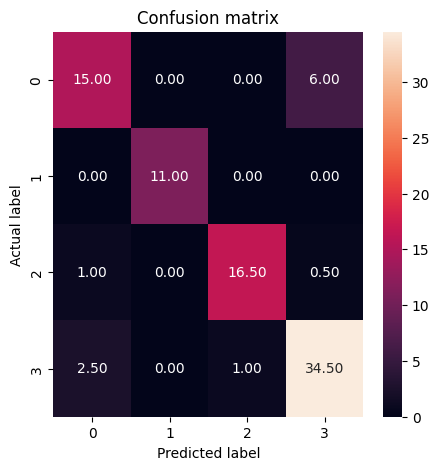

In [12]:
bent_precs, bent_recalls, bent_f1s = [], [], []
comp_precs, comp_recalls, comp_f1s = [], [], []
fri_precs, fri_recalls, fri_f1s = [], [], []
frii_precs, frii_recalls, frii_f1s = [], [], []
macro_f1s = []
average_cm = np.zeros((4, 4))
runs = 20
for run in range(1,runs+1):
    best_model = keras.models.load_model(f"../../models/merged_0.5_0.5_model{run}.h5")
    test_pred = extract_class_pred(best_model.predict(X_test))
    new_test_true, new_test_pred = process_labels(y_test, test_pred)
    cm = confusion_matrix(new_test_true, new_test_pred)
    average_cm += cm
    bent_prec, bent_recall = calc_precision_recall(cm, 0)
    bent_precs.append(bent_prec)
    bent_recalls.append(bent_recall)
    bent_f1s.append(calc_f1(bent_prec, bent_recall))
    comp_prec, comp_recall = calc_precision_recall(cm, 1)
    comp_precs.append(comp_prec)
    comp_recalls.append(comp_recall)
    comp_f1s.append(calc_f1(comp_prec, comp_recall))
    fri_prec, fri_recall = calc_precision_recall(cm, 2)
    fri_precs.append(fri_prec)
    fri_recalls.append(fri_recall)
    fri_f1s.append(calc_f1(fri_prec, fri_recall))
    frii_prec, frii_recall = calc_precision_recall(cm, 3)
    frii_precs.append(frii_prec)
    frii_recalls.append(frii_recall)
    frii_f1s.append(calc_f1(frii_prec, frii_recall))
    macro_f1s.append((bent_f1s[-1] + comp_f1s[-1] + fri_f1s[-1] + frii_f1s[-1])/4)

average_cm = average_cm/runs
print(f'Average bent precision: {np.mean(bent_precs)}')
print(f'Average bent recall: {np.mean(bent_recalls)}')
print(f'Average bent F1: {np.mean(bent_f1s)}')
print(f'Average comp precision: {np.mean(comp_precs)}')
print(f'Average comp recall: {np.mean(comp_recalls)}')
print(f'Average comp F1: {np.mean(comp_f1s)}')
print(f'Average FRI precision: {np.mean(fri_precs)}')
print(f'Average FRI recall: {np.mean(fri_recalls)}')
print(f'Average FRI F1: {np.mean(fri_f1s)}')
print(f'Average FRII precision: {np.mean(frii_precs)}')
print(f'Average FRII recall: {np.mean(frii_recalls)}')
print(f'Average FRII F1: {np.mean(frii_f1s)}')
print(f'Average Macro F1: {np.mean(macro_f1s)}')
plot_cm(average_cm)

# Heavier auxiliary weight

In [13]:
runs = 20
total_loss = 0
total_lbl_entropy = 0
total_bent_entropy = 0
total_fr_mse = 0
total_cores_mse = 0
total_size_mse = 0
total_lbl_acc = 0
total_bent_acc = 0
total_fr_mae = 0
total_cores_mae = 0
total_size_mae = 0
elapsed = 0

# Execute a few runs of training the network
for run in range(1,runs+1):
    start = time.time()
    tmp_loss, tmp_lbl_entropy, tmp_bent_entropy, tmp_fr_mse, tmp_cores_mse, tmp_size_mse, tmp_lbl_acc, tmp_bent_acc, tmp_fr_mae, tmp_cores_mae, tmp_size_mae = train_merged(X_train, y_train, y_aux_train,
                                          X_val, y_val, y_aux_val, X_test, y_test, y_aux_test, 0.25, 0.75, run)
    keras.backend.clear_session()
    end = time.time()
    elapsed += (end - start)
    total_loss += tmp_loss
    total_lbl_entropy += tmp_lbl_entropy
    total_bent_entropy += tmp_bent_entropy
    total_fr_mse += tmp_fr_mse
    total_cores_mse += tmp_cores_mse
    total_size_mse += tmp_size_mse
    total_lbl_acc += tmp_lbl_acc
    total_bent_acc += tmp_bent_acc
    total_fr_mae += tmp_fr_mae
    total_cores_mae += tmp_cores_mae
    total_size_mae += tmp_size_mae
avg_loss = total_loss/runs
avg_lbl_entropy = total_lbl_entropy/runs
avg_bent_entropy = total_bent_entropy/runs
avg_fr_mse = total_fr_mse/runs
avg_cores_mse = total_cores_mse/runs
avg_size_mse = total_size_mse/runs
avg_lbl_acc = total_lbl_acc/runs
avg_bent_acc = total_bent_acc/runs
avg_fr_mae = total_fr_mae/runs
avg_cores_mae = total_cores_mae/runs
avg_size_mae = total_size_mae/runs
avg_elapsed = elapsed/runs

Epoch 1/100
22/22 [==============================] - 8s 274ms/step - loss: 0.4660 - main_out_loss: 1.1805 - bent_out_loss: 0.5829 - fr_out_loss: 0.1052 - cores_out_loss: 0.1025 - size_out_loss: 0.1207 - main_out_categorical_accuracy: 0.5128 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.2933 - cores_out_mean_absolute_error: 0.2681 - size_out_mean_absolute_error: 0.3214 - val_loss: 0.3169 - val_main_out_loss: 0.7750 - val_bent_out_loss: 0.4269 - val_fr_out_loss: 0.0976 - val_cores_out_loss: 0.0685 - val_size_out_loss: 0.0638 - val_main_out_categorical_accuracy: 0.6207 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.2825 - val_cores_out_mean_absolute_error: 0.2252 - val_size_out_mean_absolute_error: 0.2081
Epoch 2/100
22/22 [==============================] - 8s 361ms/step - loss: 0.3386 - main_out_loss: 0.8691 - bent_out_loss: 0.4146 - fr_out_loss: 0.0931 - cores_out_loss: 0.0647 - size_out_loss: 0.0746 - main_out_categorical_accur

Epoch 12/100
22/22 [==============================] - 5s 247ms/step - loss: 0.1534 - main_out_loss: 0.3104 - bent_out_loss: 0.2487 - fr_out_loss: 0.0547 - cores_out_loss: 0.0389 - size_out_loss: 0.0618 - main_out_categorical_accuracy: 0.8903 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.1728 - cores_out_mean_absolute_error: 0.1535 - size_out_mean_absolute_error: 0.1790 - val_loss: 0.2060 - val_main_out_loss: 0.4372 - val_bent_out_loss: 0.3749 - val_fr_out_loss: 0.0559 - val_cores_out_loss: 0.0354 - val_size_out_loss: 0.0494 - val_main_out_categorical_accuracy: 0.8391 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.1756 - val_cores_out_mean_absolute_error: 0.1487 - val_size_out_mean_absolute_error: 0.1611
Epoch 13/100
22/22 [==============================] - 5s 247ms/step - loss: 0.1428 - main_out_loss: 0.2790 - bent_out_loss: 0.2415 - fr_out_loss: 0.0563 - cores_out_loss: 0.0406 - size_out_loss: 0.0514 - main_out_categorical_acc

22/22 [==============================] - 8s 360ms/step - loss: 0.2084 - main_out_loss: 0.4724 - bent_out_loss: 0.3026 - fr_out_loss: 0.0623 - cores_out_loss: 0.0492 - size_out_loss: 0.0677 - main_out_categorical_accuracy: 0.8405 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.1951 - cores_out_mean_absolute_error: 0.1779 - size_out_mean_absolute_error: 0.1987 - val_loss: 0.1999 - val_main_out_loss: 0.3966 - val_bent_out_loss: 0.3718 - val_fr_out_loss: 0.0647 - val_cores_out_loss: 0.0445 - val_size_out_loss: 0.0566 - val_main_out_categorical_accuracy: 0.8621 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.2023 - val_cores_out_mean_absolute_error: 0.1733 - val_size_out_mean_absolute_error: 0.1931
Epoch 8/100
22/22 [==============================] - 5s 247ms/step - loss: 0.1921 - main_out_loss: 0.4206 - bent_out_loss: 0.2853 - fr_out_loss: 0.0630 - cores_out_loss: 0.0486 - size_out_loss: 0.0668 - main_out_categorical_accuracy: 0.8590 

In [14]:
runs = 20
epochs_log = []
for run in range(1,runs+1):
    ea = EventAccumulator(f'../../lr_logs/merged_0.25_0.75_run{run}/train')
    ea.Reload()
    ct_loss, epochs_loss, loss = zip(*ea.Tensors('epoch_loss'))
    epochs_loss = np.asarray(epochs_loss)
    epochs_log.append(epochs_loss[-1] + 1)

epochs_log = np.array(epochs_log)
avg_epochs = np.mean(epochs_log)
min_idx = np.argmin(epochs_log) + 1
min_epochs = epochs_log[min_idx - 1]
max_idx = np.argmax(epochs_log) + 1
max_epochs = epochs_log[max_idx - 1]

In [15]:
avg_mse = (avg_fr_mse + avg_cores_mse + avg_size_mse)/3
avg_mae = (avg_fr_mae + avg_cores_mae + avg_size_mae)/3
tmp = np.array([avg_lbl_entropy, avg_bent_entropy, avg_fr_mse, avg_cores_mse, avg_size_mse, avg_lbl_acc, avg_bent_acc, avg_fr_mae, avg_cores_mae, avg_size_mae, avg_mse, avg_mae, avg_loss, avg_elapsed, avg_epochs, max_epochs, max_idx, min_epochs, min_idx])
probe_dir('../../results/')
np.save('../../results/merged_aux_results.npy', tmp)
tmp = np.load('../../results/merged_aux_results.npy')

In [16]:
print(f"Average classification entropy: {tmp[0]}")
print(f"Average bent entropy: {tmp[1]}")
print(f"Average FR ratio MSE: {tmp[2]}")
print(f"Average core count MSE: {tmp[3]}")
print(f"Average core ratio MSE: {tmp[4]}")
print(f"Average classification accuracy: {tmp[5]}")
print(f"Average bent accuracy: {tmp[6]}")
print(f"Average FR ratio MAE: {tmp[7]}")
print(f"Average core count MAE: {tmp[8]}")
print(f"Average core ratio MAE: {tmp[9]}")
print(f"Average overall MSE: {tmp[10]}")
print(f"Average overall MAE: {tmp[11]}")
print(f"Average loss: {tmp[12]}")
print(f"Average time taken: {tmp[13]}")
print(f"Average epochs taken: {tmp[14]}")
print(f"Maximum number of epochs taken was {tmp[15]} at run {tmp[16]}")
print(f"Minimum number of epochs taken was {tmp[17]} at run {tmp[18]}")

Average classification entropy: 0.4029182344675064
Average bent entropy: 0.3556395173072815
Average FR ratio MSE: 0.0647645965218544
Average core count MSE: 0.027903186157345772
Average core ratio MSE: 0.09981429949402809
Average classification accuracy: 0.8352272808551788
Average bent accuracy: 1.0
Average FR ratio MAE: 0.18615198880434036
Average core count MAE: 0.12260708585381508
Average core ratio MAE: 0.24616491794586182
Average overall MSE: 0.06416069405774276
Average overall MAE: 0.1849746642013391
Average loss: 0.2035023719072342
Average time taken: 101.91901433467865
Average epochs taken: 15.0
Maximum number of epochs taken was 15.0 at run 1.0
Minimum number of epochs taken was 15.0 at run 1.0


Average bent precision: 0.7777777777777778
Average bent recall: 0.6666666666666666
Average bent F1: 0.717948717948718
Average comp precision: 0.825
Average comp recall: 1.0
Average comp F1: 0.9013377926421404
Average FRI precision: 1.0
Average FRI recall: 0.8888888888888888
Average FRI F1: 0.9411764705882353
Average FRII precision: 0.8021978021978022
Average FRII recall: 0.8552631578947368
Average FRII F1: 0.8275974025974027
Average Macro F1: 0.847015095944124


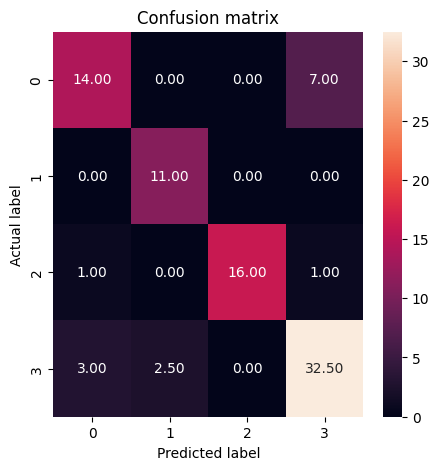

In [17]:
bent_precs, bent_recalls, bent_f1s = [], [], []
comp_precs, comp_recalls, comp_f1s = [], [], []
fri_precs, fri_recalls, fri_f1s = [], [], []
frii_precs, frii_recalls, frii_f1s = [], [], []
macro_f1s = []
average_cm = np.zeros((4, 4))
runs = 20
for run in range(1,runs+1):
    best_model = keras.models.load_model(f"../../models/merged_0.25_0.75_model{run}.h5")
    test_pred = extract_class_pred(best_model.predict(X_test))
    new_test_true, new_test_pred = process_labels(y_test, test_pred)
    cm = confusion_matrix(new_test_true, new_test_pred)
    average_cm += cm
    bent_prec, bent_recall = calc_precision_recall(cm, 0)
    bent_precs.append(bent_prec)
    bent_recalls.append(bent_recall)
    bent_f1s.append(calc_f1(bent_prec, bent_recall))
    comp_prec, comp_recall = calc_precision_recall(cm, 1)
    comp_precs.append(comp_prec)
    comp_recalls.append(comp_recall)
    comp_f1s.append(calc_f1(comp_prec, comp_recall))
    fri_prec, fri_recall = calc_precision_recall(cm, 2)
    fri_precs.append(fri_prec)
    fri_recalls.append(fri_recall)
    fri_f1s.append(calc_f1(fri_prec, fri_recall))
    frii_prec, frii_recall = calc_precision_recall(cm, 3)
    frii_precs.append(frii_prec)
    frii_recalls.append(frii_recall)
    frii_f1s.append(calc_f1(frii_prec, frii_recall))
    macro_f1s.append((bent_f1s[-1] + comp_f1s[-1] + fri_f1s[-1] + frii_f1s[-1])/4)

average_cm = average_cm/runs
print(f'Average bent precision: {np.mean(bent_precs)}')
print(f'Average bent recall: {np.mean(bent_recalls)}')
print(f'Average bent F1: {np.mean(bent_f1s)}')
print(f'Average comp precision: {np.mean(comp_precs)}')
print(f'Average comp recall: {np.mean(comp_recalls)}')
print(f'Average comp F1: {np.mean(comp_f1s)}')
print(f'Average FRI precision: {np.mean(fri_precs)}')
print(f'Average FRI recall: {np.mean(fri_recalls)}')
print(f'Average FRI F1: {np.mean(fri_f1s)}')
print(f'Average FRII precision: {np.mean(frii_precs)}')
print(f'Average FRII recall: {np.mean(frii_recalls)}')
print(f'Average FRII F1: {np.mean(frii_f1s)}')
print(f'Average Macro F1: {np.mean(macro_f1s)}')
plot_cm(average_cm)

# Heavier main weight

In [19]:
# Heavier main head
runs = 20
total_loss = 0
total_lbl_entropy = 0
total_bent_entropy = 0
total_fr_mse = 0
total_cores_mse = 0
total_size_mse = 0
total_lbl_acc = 0
total_bent_acc = 0
total_fr_mae = 0
total_cores_mae = 0
total_size_mae = 0
elapsed = 0

# Execute a few runs of training the network
for run in range(1,runs+1):
    start = time.time()
    tmp_loss, tmp_lbl_entropy, tmp_bent_entropy, tmp_fr_mse, tmp_cores_mse, tmp_size_mse, tmp_lbl_acc, tmp_bent_acc, tmp_fr_mae, tmp_cores_mae, tmp_size_mae = train_merged(X_train, y_train, y_aux_train,
                                          X_val, y_val, y_aux_val, X_test, y_test, y_aux_test, 0.75, 0.25, run)
    keras.backend.clear_session()
    end = time.time()
    elapsed += (end - start)
    total_loss += tmp_loss
    total_lbl_entropy += tmp_lbl_entropy
    total_bent_entropy += tmp_bent_entropy
    total_fr_mse += tmp_fr_mse
    total_cores_mse += tmp_cores_mse
    total_size_mse += tmp_size_mse
    total_lbl_acc += tmp_lbl_acc
    total_bent_acc += tmp_bent_acc
    total_fr_mae += tmp_fr_mae
    total_cores_mae += tmp_cores_mae
    total_size_mae += tmp_size_mae
avg_loss = total_loss/runs
avg_lbl_entropy = total_lbl_entropy/runs
avg_bent_entropy = total_bent_entropy/runs
avg_fr_mse = total_fr_mse/runs
avg_cores_mse = total_cores_mse/runs
avg_size_mse = total_size_mse/runs
avg_lbl_acc = total_lbl_acc/runs
avg_bent_acc = total_bent_acc/runs
avg_fr_mae = total_fr_mae/runs
avg_cores_mae = total_cores_mae/runs
avg_size_mae = total_size_mae/runs
avg_elapsed = elapsed/runs

Epoch 1/100
22/22 [==============================] - 8s 277ms/step - loss: 0.9930 - main_out_loss: 1.2329 - bent_out_loss: 0.7025 - fr_out_loss: 0.1153 - cores_out_loss: 0.1320 - size_out_loss: 0.1440 - main_out_categorical_accuracy: 0.4217 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.3048 - cores_out_mean_absolute_error: 0.3204 - size_out_mean_absolute_error: 0.3577 - val_loss: 0.7086 - val_main_out_loss: 0.8584 - val_bent_out_loss: 0.6775 - val_fr_out_loss: 0.1177 - val_cores_out_loss: 0.1206 - val_size_out_loss: 0.1218 - val_main_out_categorical_accuracy: 0.5747 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.3147 - val_cores_out_mean_absolute_error: 0.3090 - val_size_out_mean_absolute_error: 0.3267
Epoch 2/100
22/22 [==============================] - 8s 358ms/step - loss: 0.7658 - main_out_loss: 0.9452 - bent_out_loss: 0.5962 - fr_out_loss: 0.1095 - cores_out_loss: 0.0983 - size_out_loss: 0.1057 - main_out_categorical_accur

Epoch 12/100
22/22 [==============================] - 8s 359ms/step - loss: 0.2603 - main_out_loss: 0.2988 - bent_out_loss: 0.3405 - fr_out_loss: 0.0918 - cores_out_loss: 0.0622 - size_out_loss: 0.0844 - main_out_categorical_accuracy: 0.9060 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.2487 - cores_out_mean_absolute_error: 0.2055 - size_out_mean_absolute_error: 0.2452 - val_loss: 0.2907 - val_main_out_loss: 0.3375 - val_bent_out_loss: 0.3910 - val_fr_out_loss: 0.0844 - val_cores_out_loss: 0.0558 - val_size_out_loss: 0.0703 - val_main_out_categorical_accuracy: 0.8966 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.2448 - val_cores_out_mean_absolute_error: 0.2061 - val_size_out_mean_absolute_error: 0.2392
Epoch 13/100
22/22 [==============================] - 5s 243ms/step - loss: 0.2132 - main_out_loss: 0.2369 - bent_out_loss: 0.3355 - fr_out_loss: 0.0860 - cores_out_loss: 0.0640 - size_out_loss: 0.0833 - main_out_categorical_acc

22/22 [==============================] - 8s 360ms/step - loss: 0.6771 - main_out_loss: 0.8294 - bent_out_loss: 0.5396 - fr_out_loss: 0.1146 - cores_out_loss: 0.0989 - size_out_loss: 0.1279 - main_out_categorical_accuracy: 0.6567 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.2997 - cores_out_mean_absolute_error: 0.2653 - size_out_mean_absolute_error: 0.3336 - val_loss: 0.5216 - val_main_out_loss: 0.6300 - val_bent_out_loss: 0.4747 - val_fr_out_loss: 0.1241 - val_cores_out_loss: 0.0793 - val_size_out_loss: 0.1079 - val_main_out_categorical_accuracy: 0.7471 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.3158 - val_cores_out_mean_absolute_error: 0.2419 - val_size_out_mean_absolute_error: 0.3143
Epoch 4/100
22/22 [==============================] - 8s 352ms/step - loss: 0.5313 - main_out_loss: 0.6402 - bent_out_loss: 0.4994 - fr_out_loss: 0.1101 - cores_out_loss: 0.0810 - size_out_loss: 0.1275 - main_out_categorical_accuracy: 0.7521 

Epoch 14/100
22/22 [==============================] - 8s 359ms/step - loss: 0.2467 - main_out_loss: 0.2804 - bent_out_loss: 0.3565 - fr_out_loss: 0.0864 - cores_out_loss: 0.0572 - size_out_loss: 0.0827 - main_out_categorical_accuracy: 0.9117 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.2408 - cores_out_mean_absolute_error: 0.1989 - size_out_mean_absolute_error: 0.2366 - val_loss: 0.2903 - val_main_out_loss: 0.3378 - val_bent_out_loss: 0.4001 - val_fr_out_loss: 0.0776 - val_cores_out_loss: 0.0498 - val_size_out_loss: 0.0631 - val_main_out_categorical_accuracy: 0.8736 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.2313 - val_cores_out_mean_absolute_error: 0.1972 - val_size_out_mean_absolute_error: 0.2149
Epoch 15/100
22/22 [==============================] - 5s 243ms/step - loss: 0.2311 - main_out_loss: 0.2616 - bent_out_loss: 0.3455 - fr_out_loss: 0.0746 - cores_out_loss: 0.0640 - size_out_loss: 0.0748 - main_out_categorical_acc

In [20]:
runs = 20
epochs_log = []
for run in range(1,runs+1):
    ea = EventAccumulator(f'../../lr_logs/merged_0.75_0.25_run{run}/train')
    ea.Reload()
    ct_loss, epochs_loss, loss = zip(*ea.Tensors('epoch_loss'))
    epochs_loss = np.asarray(epochs_loss)
    epochs_log.append(epochs_loss[-1] + 1)

epochs_log = np.array(epochs_log)
avg_epochs = np.mean(epochs_log)
min_idx = np.argmin(epochs_log) + 1
min_epochs = epochs_log[min_idx - 1]
max_idx = np.argmax(epochs_log) + 1
max_epochs = epochs_log[max_idx - 1]

In [21]:
avg_mse = (avg_fr_mse + avg_cores_mse + avg_size_mse)/3
avg_mae = (avg_fr_mae + avg_cores_mae + avg_size_mae)/3
tmp = np.array([avg_lbl_entropy, avg_bent_entropy, avg_fr_mse, avg_cores_mse, avg_size_mse, avg_lbl_acc, avg_bent_acc, avg_fr_mae, avg_cores_mae, avg_size_mae, avg_mse, avg_mae, avg_loss, avg_elapsed, avg_epochs, max_epochs, max_idx, min_epochs, min_idx])
probe_dir('../../results/')
np.save('../../results/merged_main_results.npy', tmp)
tmp = np.load('../../results/merged_main_results.npy')

In [22]:
print(f"Average classification entropy: {tmp[0]}")
print(f"Average bent entropy: {tmp[1]}")
print(f"Average FR ratio MSE: {tmp[2]}")
print(f"Average core count MSE: {tmp[3]}")
print(f"Average core ratio MSE: {tmp[4]}")
print(f"Average classification accuracy: {tmp[5]}")
print(f"Average bent accuracy: {tmp[6]}")
print(f"Average FR ratio MAE: {tmp[7]}")
print(f"Average core count MAE: {tmp[8]}")
print(f"Average core ratio MAE: {tmp[9]}")
print(f"Average overall MSE: {tmp[10]}")
print(f"Average overall MAE: {tmp[11]}")
print(f"Average loss: {tmp[12]}")
print(f"Average time taken: {tmp[13]}")
print(f"Average epochs taken: {tmp[14]}")
print(f"Maximum number of epochs taken was {tmp[15]} at run {tmp[16]}")
print(f"Minimum number of epochs taken was {tmp[17]} at run {tmp[18]}")

Average classification entropy: 0.3658653199672699
Average bent entropy: 0.3788503408432007
Average FR ratio MSE: 0.06988950818777084
Average core count MSE: 0.042030055075883865
Average core ratio MSE: 0.12276140600442886
Average classification accuracy: 0.8522727489471436
Average bent accuracy: 1.0
Average FR ratio MAE: 0.20941162109375
Average core count MAE: 0.16605954617261887
Average core ratio MAE: 0.30715136229991913
Average overall MSE: 0.07822698975602786
Average overall MAE: 0.22754084318876266
Average loss: 0.3127446919679642
Average time taken: 121.9546308517456
Average epochs taken: 19.0
Maximum number of epochs taken was 19.0 at run 1.0
Minimum number of epochs taken was 19.0 at run 1.0


Average bent precision: 0.7507739938080495
Average bent recall: 0.6428571428571428
Average bent F1: 0.6921052631578948
Average comp precision: 1.0
Average comp recall: 1.0
Average comp F1: 1.0
Average FRI precision: 1.0
Average FRI recall: 0.8611111111111112
Average FRI F1: 0.9251336898395721
Average FRII precision: 0.8047040169133193
Average FRII recall: 0.9210526315789473
Average FRII F1: 0.8589280337247815
Average Macro F1: 0.8690417466805621


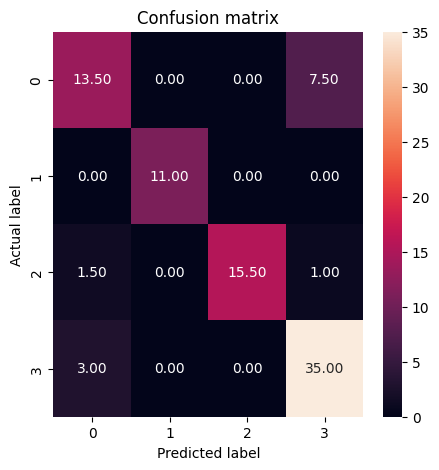

In [23]:
bent_precs, bent_recalls, bent_f1s = [], [], []
comp_precs, comp_recalls, comp_f1s = [], [], []
fri_precs, fri_recalls, fri_f1s = [], [], []
frii_precs, frii_recalls, frii_f1s = [], [], []
macro_f1s = []
average_cm = np.zeros((4, 4))
runs = 20
for run in range(1,runs+1):
    best_model = keras.models.load_model(f"../../models/merged_0.75_0.25_model{run}.h5")
    test_pred = extract_class_pred(best_model.predict(X_test))
    new_test_true, new_test_pred = process_labels(y_test, test_pred)
    cm = confusion_matrix(new_test_true, new_test_pred)
    average_cm += cm
    bent_prec, bent_recall = calc_precision_recall(cm, 0)
    bent_precs.append(bent_prec)
    bent_recalls.append(bent_recall)
    bent_f1s.append(calc_f1(bent_prec, bent_recall))
    comp_prec, comp_recall = calc_precision_recall(cm, 1)
    comp_precs.append(comp_prec)
    comp_recalls.append(comp_recall)
    comp_f1s.append(calc_f1(comp_prec, comp_recall))
    fri_prec, fri_recall = calc_precision_recall(cm, 2)
    fri_precs.append(fri_prec)
    fri_recalls.append(fri_recall)
    fri_f1s.append(calc_f1(fri_prec, fri_recall))
    frii_prec, frii_recall = calc_precision_recall(cm, 3)
    frii_precs.append(frii_prec)
    frii_recalls.append(frii_recall)
    frii_f1s.append(calc_f1(frii_prec, frii_recall))
    macro_f1s.append((bent_f1s[-1] + comp_f1s[-1] + fri_f1s[-1] + frii_f1s[-1])/4)

average_cm = average_cm/runs
print(f'Average bent precision: {np.mean(bent_precs)}')
print(f'Average bent recall: {np.mean(bent_recalls)}')
print(f'Average bent F1: {np.mean(bent_f1s)}')
print(f'Average comp precision: {np.mean(comp_precs)}')
print(f'Average comp recall: {np.mean(comp_recalls)}')
print(f'Average comp F1: {np.mean(comp_f1s)}')
print(f'Average FRI precision: {np.mean(fri_precs)}')
print(f'Average FRI recall: {np.mean(fri_recalls)}')
print(f'Average FRI F1: {np.mean(fri_f1s)}')
print(f'Average FRII precision: {np.mean(frii_precs)}')
print(f'Average FRII recall: {np.mean(frii_recalls)}')
print(f'Average FRII F1: {np.mean(frii_f1s)}')
print(f'Average Macro F1: {np.mean(macro_f1s)}')
plot_cm(average_cm)